In [37]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3      ✔ yardstick 0.0.7 

Warning message:
“package ‘broom’ was built under R version 4.0.2”
Warning message:
“package ‘dials’ was built under R version 4.0.2”
Warning message:
“package ‘infer’ was built under R version 4.0.3”
Warning message:
“package ‘modeldata’ was built under R version 4.0.1”
Warning message:
“package ‘parsnip’ was built under R version 4.0.2”
Warning message:
“package ‘recipes’ was built under R version 4.0.1”
Warning message:
“package ‘tune’ was built under R version 4.0.2”
Warning message:
“package ‘workflows’ was built under R version 4.0.2”
Warning message:
“package ‘yardstick’ was built under R version 4.0.2”
── Conflicts ────

## Preliminary Exploratory Data Analysis:
1) Reading the dataset from the web into R

In [86]:
forest_fire_data_raw <- read.csv("https://archive.ics.uci.edu/ml/machine-learning-databases/00547/Algerian_forest_fires_dataset_UPDATE.csv", skip = 1)
head(forest_fire_data_raw) #previewing the first 6 rows of the dataset

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,01,06,2012,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,not fire
2,02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire
3,03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire
4,04,06,2012,25,89,13,2.5,28.6,1.3,6.9,0,1.7,0,not fire
5,05,06,2012,27,77,16,0,64.8,3,14.2,1.2,3.9,0.5,not fire
6,06,06,2012,31,67,14,0,82.6,5.8,22.2,3.1,7,2.5,fire


Here is what the column headings mean:
* day/month/year: indicate the day/month/year that the observation was taken, respectively.
* Temperature: Maximum Temperature on that day (Celsius)
* RH: Realtive Humidity (%)
* Ws: Wind Speed (km/h)
* Rain: Total that day (mm)
* FFMC: Fine Fuel Moisture Code Index from FWI system
* DMC: Duff Moisture Code Index from FWI system
* DC: Drought Code Index from FWI system
* ISI: Initial Spread Index from FWI system
* BUI: Buildup index from FWI system
* FWI: Fire Weather Index
* Classes: either "not fire" or "fire"

2) Cleaning and Wrangling the Data into a Tidy Format
* The data is not in a tidy form as the data actually contains two regions of observations. Rows 1-122 are observations for the Bejaia Region, while rows 125 to 246 are for the Sidi-Bel Abbes Region (rows 123 and 124 contain column headers). To tidy this, an extra column called "region" will be created. After this all observations will be tidy, as they are split into individual rows, each column is a single variable and each value is in a single cell.
* We also noticed that for the 14/07/2012 data point (row 166 for the forest_fire_data_tidy dataframe) in the Sidi-Bel Abbes Region, the original dataset had a typo in it, where they forgot the delim between the ISI and BUI columns. To fix this, we removed that datapoint and replaced it with one that is correctly written (but did not change the values).
* Additionally, to make the data more usable, we decided to convert some of the columns from characters to factors (Classes) and numeric values (Temperature:FWI).

In [184]:
forest_fire_data_collect <- collect(forest_fire_data_raw)

forest_fire_data_bejaia <- forest_fire_data_collect %>% 
    slice(1:122) %>%
    mutate(region = "Bejaia")

forest_fire_data_sidibel <- forest_fire_data_collect %>%
    slice(125:246) %>%
    mutate(region = "Sidi-Bel_Abbes")

forest_fire_data_tidy <- rbind(forest_fire_data_bejaia,forest_fire_data_sidibel)

forest_fire_fix <- forest_fire_data_tidy %>%
    slice(-166) %>%
    add_row(day = "14", month = "07", year = "2012", Temperature = "37",RH = "37",Ws = "18",Rain = "0.2",FFMC = "88.9",DMC = "12.9",DC = "14.6",ISI = "9", BUI = "12.5", FWI = "10.4", Classes = "fire",region = "Sidi-Bel_Abbes")

forest_fire_fix

forest_fire_data_mutated <- forest_fire_fix %>%
    mutate(Classes = as.factor(Classes),
           Temperature = as.numeric(Temperature, na.rm = TRUE),
           RH = as.numeric(RH, na.rm = TRUE),
           Ws = as.numeric(Ws, na.rm = TRUE),
           Rain = as.numeric(Rain, na.rm = TRUE),
           FFMC = as.numeric(FFMC, na.rm = TRUE),
           DMC = as.numeric(DMC, na.rm = TRUE),
           DC = as.numeric(DC, na.rm = TRUE),
           ISI = as.numeric(ISI, na.rm = TRUE),
           BUI = as.numeric(BUI, na.rm = TRUE),
           FWI = as.numeric(FWI, na.rm = TRUE))

forest_fire_data_mutated

day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,region
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
01,06,2012,29,57,18,0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,Bejaia
02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1,3.9,0.4,not fire,Bejaia
03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,Bejaia
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
29,09,2012,24,54,18,0.1,79.7,4.3,15.2,1.7,5.1,0.7,not fire,Sidi-Bel_Abbes
30,09,2012,24,64,15,0.2,67.3,3.8,16.5,1.2,4.8,0.5,not fire,Sidi-Bel_Abbes
14,07,2012,37,37,18,0.2,88.9,12.9,14.6,9,12.5,10.4,fire,Sidi-Bel_Abbes


'data.frame':	244 obs. of  15 variables:
 $ day        : chr  "01" "02" "03" "04" ...
 $ month      : chr  "06" "06" "06" "06" ...
 $ year       : chr  "2012" "2012" "2012" "2012" ...
 $ Temperature: num  29 29 26 25 27 31 33 30 25 28 ...
 $ RH         : num  57 61 82 89 77 67 54 73 88 79 ...
 $ Ws         : num  18 13 22 13 16 14 13 15 13 12 ...
 $ Rain       : num  0 1.3 13.1 2.5 0 0 0 0 0.2 0 ...
 $ FFMC       : num  65.7 64.4 47.1 28.6 64.8 82.6 88.2 86.6 52.9 73.2 ...
 $ DMC        : num  3.4 4.1 2.5 1.3 3 5.8 9.9 12.1 7.9 9.5 ...
 $ DC         : num  7.6 7.6 7.1 6.9 14.2 22.2 30.5 38.3 38.8 46.3 ...
 $ ISI        : num  1.3 1 0.3 0 1.2 3.1 6.4 5.6 0.4 1.3 ...
 $ BUI        : num  3.4 3.9 2.7 1.7 3.9 7 10.9 13.5 10.5 12.6 ...
 $ FWI        : num  0.5 0.4 0.1 0 0.5 2.5 7.2 7.1 0.3 0.9 ...
 $ Classes    : Factor w/ 8 levels "fire","fire ",..: 6 6 6 6 6 3 3 3 6 6 ...
 $ region     : chr  "Bejaia" "Bejaia" "Bejaia" "Bejaia" ...


### Extracting Training Data
* 75% of the data was used as training data in this analysis

In [155]:
set.seed(3456) 

forest_split <- initial_split(forest_fire_data_mutated, prop = 0.75, strata = Classes)  
forest_fire_training <- training(forest_split)   
forest_fire_testing <- testing(forest_split)

head(forest_fire_training)

,day,month,year,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes,region
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
1,01,06,2012,29,57,18,0.0,65.7,3.4,7.6,1.3,3.4,0.5,not fire,Bejaia
2,02,06,2012,29,61,13,1.3,64.4,4.1,7.6,1.0,3.9,0.4,not fire,Bejaia
3,03,06,2012,26,82,22,13.1,47.1,2.5,7.1,0.3,2.7,0.1,not fire,Bejaia
4,04,06,2012,25,89,13,2.5,28.6,1.3,6.9,0.0,1.7,0.0,not fire,Bejaia
5,05,06,2012,27,77,16,0.0,64.8,3.0,14.2,1.2,3.9,0.5,not fire,Bejaia
6,06,06,2012,31,67,14,0.0,82.6,5.8,22.2,3.1,7.0,2.5,fire,Bejaia


3) Creating a Summary Table
* We wanted to create a summary table that showed the number of observations in both the "fire" and "not fire" classes that we are using as well as the means of the predictor variables we plan to use (Temperature:Rain).

In [157]:
fail()
forest_fire_means <- forest_fire_training %>%
    group_by(Temperature, RH, Ws, Rain) %>%
    summarize(mean_temp = mean(Temperature),
             mean_RH = mean(RH),
             mean_Ws = mean(Ws),
             mean_rain = mean(rain))
    
forest_fire_means


# forest_fire_summary <- forest_fire_training %>%
#     group_by(Classes) %>%
#     summarize(n = n()) 

# forest_fire_summary

ERROR: Error in fail(): could not find function "fail"


4) Creating a Vsiaulization for Our Training Data
* We wanted to visualize the distributions of our predictor variables (Temperature:Rain)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



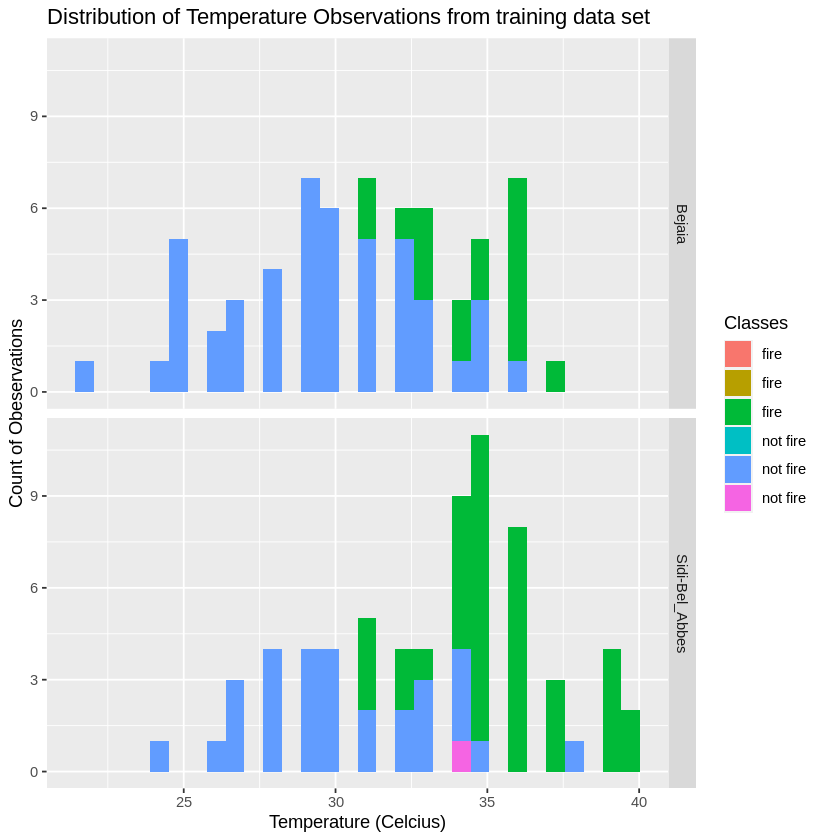

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



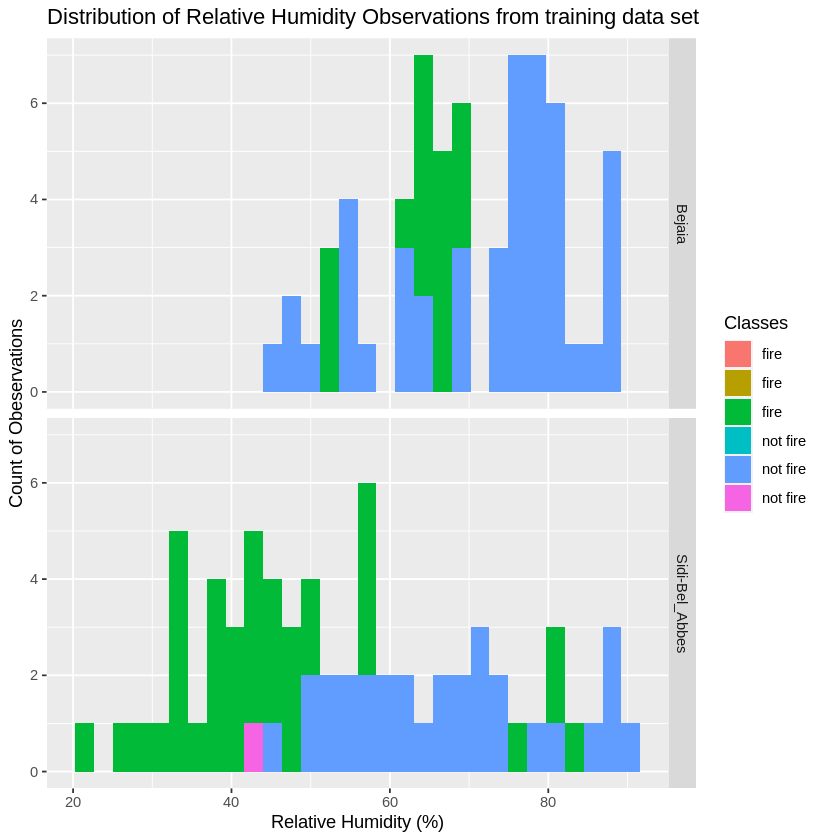

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



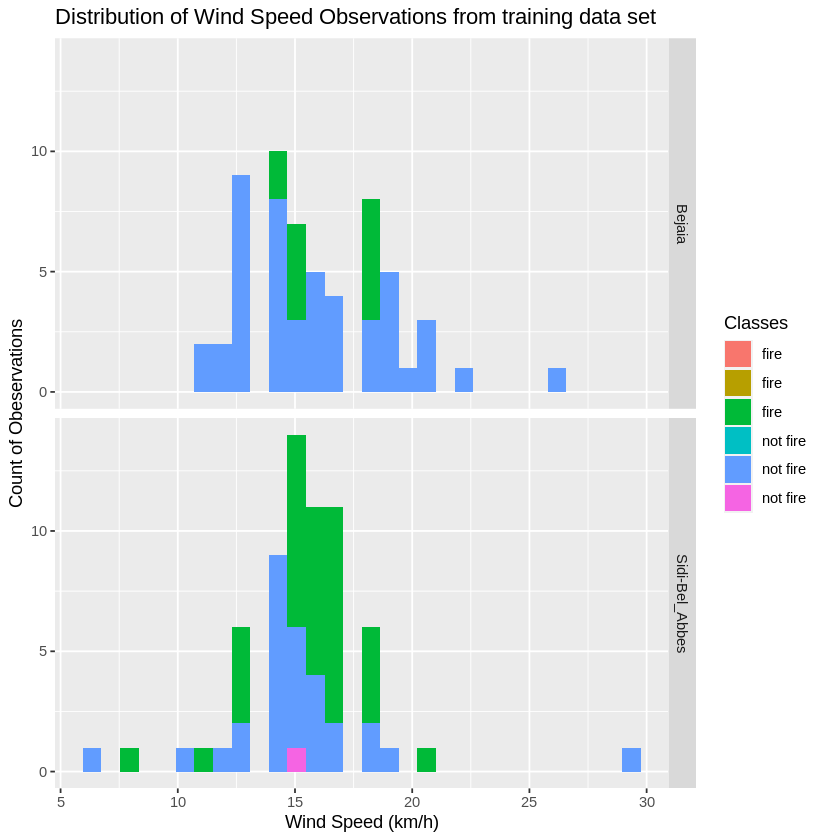

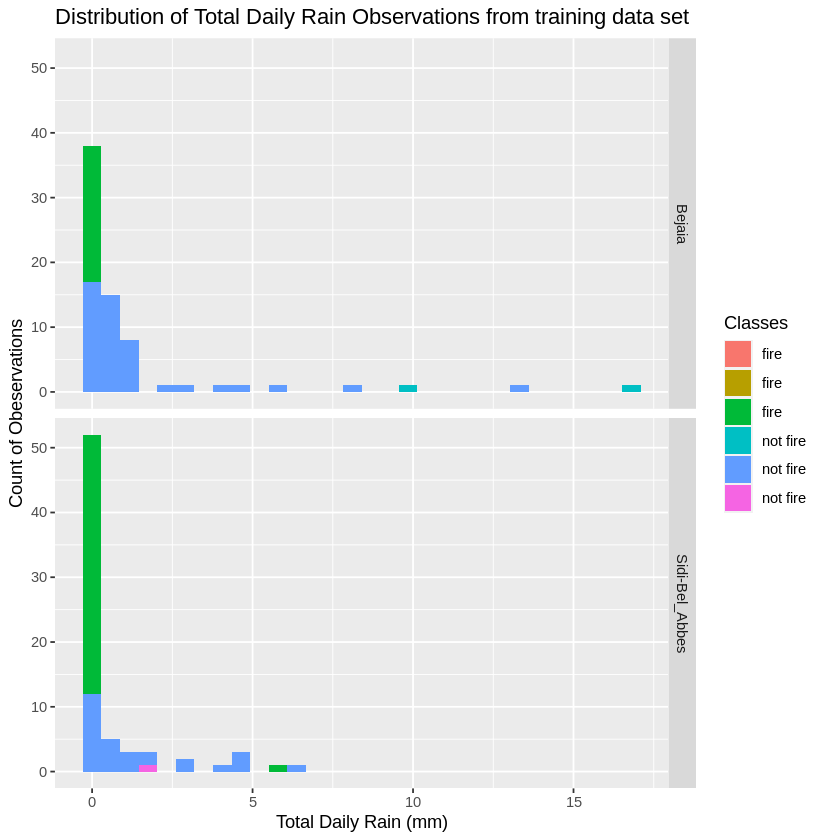

In [178]:
forest_fire_visualization_temperature <- forest_fire_training %>%
    ggplot(aes(x = Temperature, fill = Classes)) +
    facet_grid(region ~ .) +
    geom_histogram(position = "identity") +
    labs(x = "Temperature (Celcius)", y = "Count of Obeservations",
         title = "Distribution of Temperature Observations from training data set")

forest_fire_visualization_temperature

forest_fire_visualization_RH <- forest_fire_training %>%
    ggplot(aes(x = RH, fill = Classes)) +
    facet_grid(region ~ .) +
    geom_histogram(position = "identity") +
    labs(x = "Relative Humidity (%)", y = "Count of Obeservations",
         title = "Distribution of Relative Humidity Observations from training data set")

forest_fire_visualization_RH

forest_fire_visualization_Ws <- forest_fire_training %>%
    ggplot(aes(x = Ws, fill = Classes)) +
    facet_grid(region ~ .) +
    geom_histogram(position = "identity") +
    labs(x = "Wind Speed (km/h)", y = "Count of Obeservations",
         title = "Distribution of Wind Speed Observations from training data set")

forest_fire_visualization_Ws

forest_fire_visualization_Rain <- forest_fire_training %>%
    ggplot(aes(x = Rain, fill = Classes)) +
    facet_grid(region ~ .) +
    geom_histogram(position = "identity") +
    labs(x = "Total Daily Rain (mm)", y = "Count of Obeservations",
         title = "Distribution of Total Daily Rain Observations from training data set")

forest_fire_visualization_Rain